<a href="https://colab.research.google.com/github/ravichas/bifx-546/blob/main/Notebooks/Chapter07_HypothesisTesting_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 07: Hypothesis Testing Exercise

## 🎓 Course Context  
Prepared for **BIFX-546 – Machine Learning for Bioinformatics**  
Instructor: **Sarangan Ravichandran, PhD., PMP**

---

## 📘 Attribution & Reading Reference  
This notebook is based on concepts, structure and examples from:  
**Data Science from Scratch (2nd Edition)** by **Joel Grus**, O’Reilly Media, Inc.

**Relevant Reading:**  
*Data Science from Scratch (2nd Edition)* — **Chapter 07: Hypothesis Testing**

# 0) Setup Cell (Code)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Reproducibility Control

In [ ]:
# Reproducibility control
# For identical results across students, keep this fixed.
# For exploration, change the number or comment it out.
np.random.seed(42)

# 1) What are we testing?

## 1. Problem Setup (Bioinformatics Scenario)

We are studying a gene suspected to be **upregulated in cancer**.

We have expression measurements from:

- **Control group** (healthy tissue)
- **Case group** (tumor tissue)

**Question:**  
Do we have enough evidence to conclude the gene is upregulated in cancer?

---

### Hypotheses

**Null hypothesis (H₀):** The mean expression is the same in both groups.  
$
 H_0: \mu_{case} = \mu_{control}
$

**Alternative hypothesis (Hₐ):** The gene is upregulated in cancer.  
$
H_A: \mu_{case} > \mu_{control}
$

This is a **one-sided** test because the biology motivates a directional claim (upregulation).

# 2) Generate / Load Data

## 2. Data

In real genomics workflows, data would come from RNA-seq pipelines (e.g., normalized counts / log-CPM / TPM).

For hands-on learning, we will **simulate** gene expression values so we control the ground truth.

# 2a) Simulate Data

In [ ]:
n_control = 40
n_case = 40

# Simulated gene expression (e.g., log-normalized counts)
control = np.random.normal(loc=5.2, scale=0.8, size=n_control)
case    = np.random.normal(loc=6.0, scale=0.9, size=n_case)

df = pd.DataFrame({
    "expression": np.concatenate([control, case]),
    "group": ["Control"] * n_control + ["Cancer"] * n_case
})

df.head()

,expression,group
0,5.597371,Control
1,5.089389,Control
2,5.718151,Control
3,6.418424,Control
4,5.012677,Control


# 2b) Quick Summary

In [ ]:
df.groupby("group")["expression"].agg(["count", "mean", "std"])

,count,mean,std
group,,,
Cancer,40,5.973861,0.868291
Control,40,5.025091,0.762247


# 3) Visualize

## 3. Visualize the Distributions

Before computing any p-values, we should **look at the data**:

- Are the distributions shifted?
- Are there outliers?
- Are spreads similar?

A statistical test should support what we see visually (or reveal what is subtle).

# 3a) Boxplot

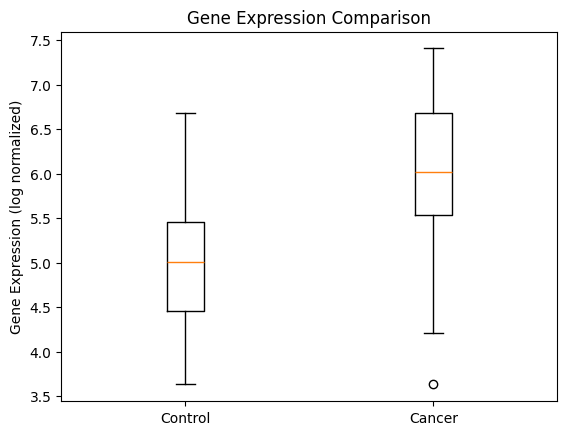

In [ ]:
control_vals = df[df["group"] == "Control"]["expression"].values
case_vals    = df[df["group"] == "Cancer"]["expression"].values

plt.boxplot([control_vals, case_vals], tick_labels=["Control", "Cancer"], showfliers=True)
plt.ylabel("Gene Expression (log normalized)")
plt.title("Gene Expression Comparison")
plt.show()

# 3b) Histogram Overlay

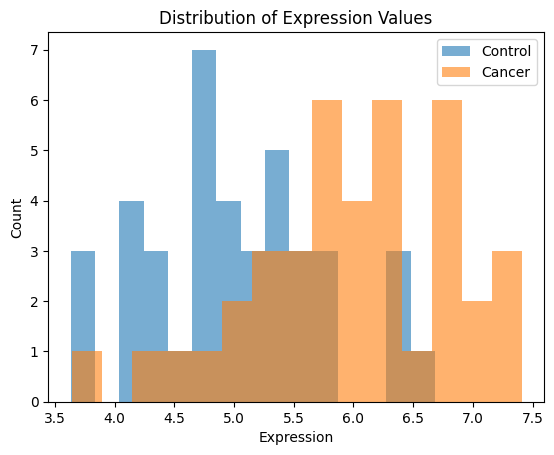

In [ ]:
plt.hist(control_vals, bins=15, alpha=0.6, label="Control")
plt.hist(case_vals, bins=15, alpha=0.6, label="Cancer")
plt.xlabel("Expression")
plt.ylabel("Count")
plt.title("Distribution of Expression Values")
plt.legend()
plt.show()

# 4) Test Statistic

## 4. Test Statistic: Difference in Means

We will use a simple test statistic:
\[
T = \bar{x}_{case} - \bar{x}_{control}
\]

If the gene is upregulated in cancer, we expect **T > 0**.

In [ ]:
observed_diff = case_vals.mean() - control_vals.mean()
observed_diff

np.float64(0.9487703523757061)

# 5) Hypothesis Testing “From Scratch” (Permutation Test)

## 5. Permutation Test (Joel Grus Style)

**Idea:**  
If the null hypothesis is true (no group difference), then group labels are arbitrary.

So we:
1. Combine all values
2. Shuffle labels
3. Recompute the difference in means
4. Repeat many times to build a null distribution
5. Compute the p-value as:
\[
p = P(T_{null} \ge T_{observed})
\]
(One-sided)

In [ ]:
combined = np.concatenate([control_vals, case_vals])
n = len(control_vals)

iterations = 5000
null_diffs = np.empty(iterations)

for i in range(iterations):
    shuffled = np.random.permutation(combined)
    new_control = shuffled[:n]
    new_case = shuffled[n:]
    null_diffs[i] = new_case.mean() - new_control.mean()

p_perm = np.mean(null_diffs >= observed_diff)

observed_diff, p_perm

(np.float64(0.9487703523757061), np.float64(0.0))

# 5b) Visualize Null Distribution

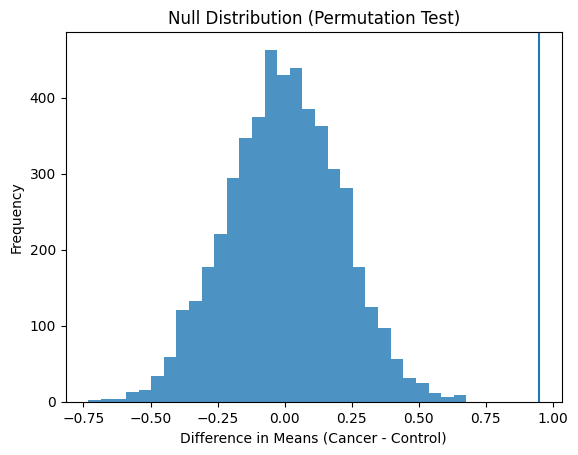

In [ ]:
plt.hist(null_diffs, bins=30, alpha=0.8)
plt.axvline(observed_diff)  # observed statistic
plt.title("Null Distribution (Permutation Test)")
plt.xlabel("Difference in Means (Cancer - Control)")
plt.ylabel("Frequency")
plt.show()

# 6) Compare with Classical T-Test

## 6. Compare with a Classical t-Test (Reference)

In practice, many workflows use a t-test (or more advanced models like limma/DESeq2).

We include this here for comparison.

**Note:** Our primary learning objective is understanding the logic of hypothesis testing,
not memorizing scipy functions.

In [ ]:
from scipy import stats

t_stat, p_two_sided = stats.ttest_ind(case_vals, control_vals, equal_var=False)
p_one_sided = p_two_sided / 2 if t_stat > 0 else 1 - (p_two_sided / 2)

t_stat, p_two_sided, p_one_sided

(np.float64(5.19348207496211),
 np.float64(1.6485841608239762e-06),
 np.float64(8.242920804119881e-07))

# 7) Effect Size

## 7. Effect Size (Statistical vs Biological Significance)

A small p-value can happen with:
- a large effect, OR
- a tiny effect + huge sample size

So we compute an effect size (Cohen's d-like):
\[
d = \frac{\bar{x}_{case} - \bar{x}_{control}}{s_{pooled}}
\]

In [ ]:
pooled_std = np.std(np.concatenate([control_vals, case_vals]), ddof=1)
effect_size = observed_diff / pooled_std
effect_size

np.float64(1.0074416908365544)

# Pause

Answer:

* Before computing p-value, what do you predict?
* Is this biologically meaningful?

# 8) Interpretation

## 8. Interpretation

1. What is the observed difference in means?  
2. What is the permutation p-value?  
3. What is the one-sided t-test p-value?  
4. Do you reject H₀ at α = 0.05? Why or why not?  
5. Is the effect size biologically meaningful?  
6. What assumptions are being made?  
7. If we increased the sample size from 40 → 400 per group, what would likely happen to the p-value? Why?  

---

## 8A. Exploration: Sampling Variability & Stability

Now investigate how stable your conclusion is.

### Task 1 – Change the Random Seed
- Modify the `np.random.seed()` value (or comment it out).
- Re-run the notebook.
- Does your p-value change?
- Does your conclusion change?
- Why does this happen?

---

### Task 2 – Reduce the Sample Size
- Change n from 40 → 20 per group.
- Re-run the analysis.
- What happens to:
  - Observed difference?
  - p-value?
  - Effect size?
- Why?

---

### Task 3 – Increase the Sample Size
- Change n from 40 → 400 per group.
- Re-run the analysis.
- What happens to the p-value?
- Does statistical significance increase even if the effect size stays similar?

---

### Task 4 – Reduce the True Effect
- Change the cancer mean from 6.0 → 5.4.
- Re-run the analysis.
- What happens?
- Can a small effect still become “statistically significant” with large n?

---

## Reflection

In 3–5 sentences:

- When is statistical significance misleading?
- How does this connect to large-scale genomics studies?

# 9) Extension: Sample Size Sensitivity

In [ ]:
def simulate_and_test(n=40, mu_control=5.2, mu_case=6.0, sd_control=0.8, sd_case=0.9, iters=2000):
    control = np.random.normal(mu_control, sd_control, n)
    case = np.random.normal(mu_case, sd_case, n)
    observed = case.mean() - control.mean()
    combined = np.concatenate([control, case])

    null = []
    for _ in range(iters):
        shuffled = np.random.permutation(combined)
        null.append(shuffled[n:].mean() - shuffled[:n].mean())
    null = np.array(null)
    p = np.mean(null >= observed)
    return observed, p

for n in [20, 40, 80, 200, 400]:
    obs, p = simulate_and_test(n=n)
    print(f"n={n:>3}  observed_diff={obs:.3f}  perm_p={p:.4f}")

n= 20  observed_diff=0.756  perm_p=0.0110
n= 40  observed_diff=0.673  perm_p=0.0000
n= 80  observed_diff=0.787  perm_p=0.0000
n=200  observed_diff=0.736  perm_p=0.0000
n=400  observed_diff=0.915  perm_p=0.0000


# 10) Wrap-Up

## 10. Wrap-Up

### What you should take away
- Hypothesis testing is about **comparing an observed statistic** to a **null distribution**
- A p-value answers:  
  *"If H₀ were true, how surprising is the observed result?"*
- Always pair **p-values** with **effect sizes** and **domain interpretation**

### Looking ahead
In real genomics:
- We test thousands of genes → **multiple testing**
- We control false discoveries → **FDR / Benjamini-Hochberg**
- We often use specialized models (limma, DESeq2)

We will connect this to modeling and evaluation later in the course.